Librerias

Graficar en el tiempo señales

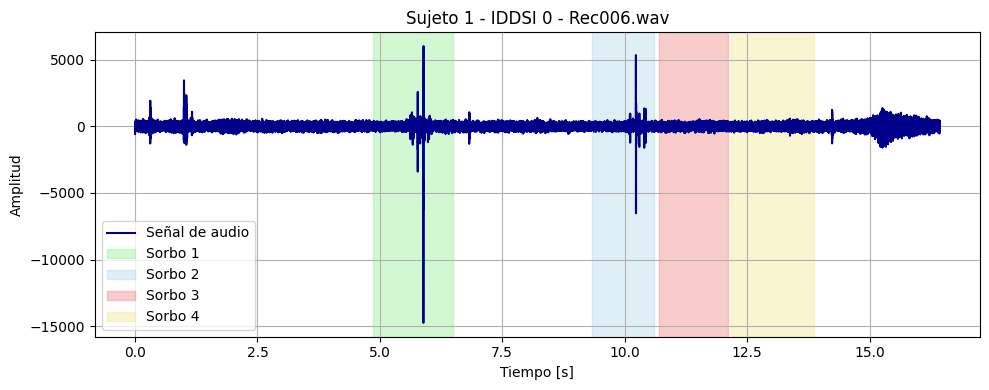

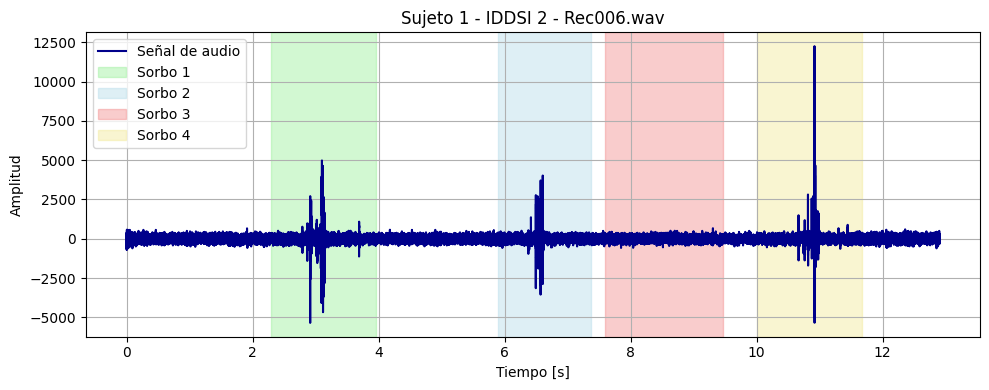

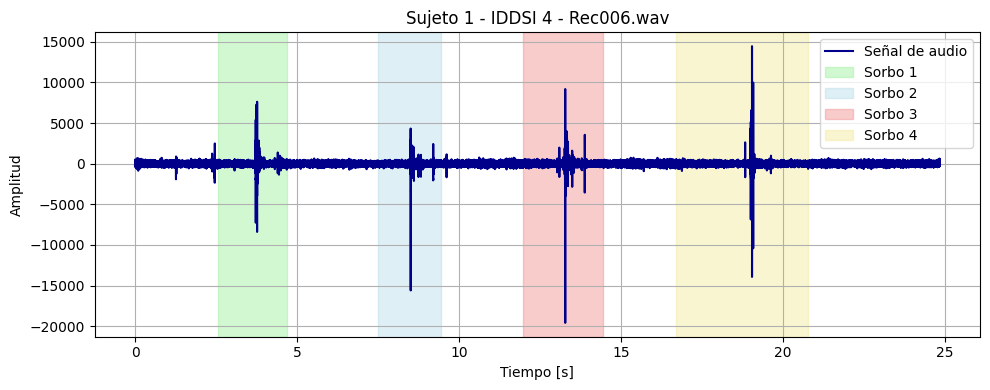

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile


ruta_audio = "audios/Rec006.wav"

# Rutas
carpeta_etiquetas = "etiquetas"
tabla = pd.read_excel("tiempo_recortes_sincronizados.xlsx")
tabla["ID_audio"] = tabla["ID_audio"].str.strip()
nombre_audio = os.path.basename(ruta_audio).strip()
filas_audio = tabla[tabla["ID_audio"] == nombre_audio]

if filas_audio.empty:
    print(f"No se encontraron datos en la tabla para el audio: {nombre_audio}")
else:
    fs, audio = wavfile.read(ruta_audio)
    if audio.ndim > 1:
        audio = audio[:, 0]
    tiempo = np.linspace(0, len(audio) / fs, len(audio))
    colores = ['lightgreen', 'lightblue', 'lightcoral', 'khaki', 'plum', 'lightgray']

    for _, fila in filas_audio.iterrows():
        sujeto_str = fila["ID_Voluntario"]  # Ej: 'Sujeto 1'
        sujeto = sujeto_str.split()[-1]     # Solo el número: '1'
        iddsi = fila["IDDSI"]
        t_inicio = fila["cut_i_audio"]
        t_fin = fila["cut_f_audio"]

        # Cortar señal
        idx_inicio = int(t_inicio * fs)
        idx_fin = int(t_fin * fs)
        audio_segmento = audio[idx_inicio:idx_fin]
        tiempo_segmento = tiempo[idx_inicio:idx_fin] - t_inicio

        # Cargar etiquetas
        nombre_etiqueta = f"IDDSI{iddsi}_S{sujeto}.txt"
        ruta_etiqueta = os.path.join(carpeta_etiquetas, nombre_etiqueta)
        etiquetas = []
        if os.path.exists(ruta_etiqueta):
            try:
                etiquetas_df = pd.read_csv(ruta_etiqueta, sep="\t")
                for i, row in etiquetas_df.iterrows():
                    etiquetas.append((row['i_deg'], row['f_deg'], f"Sorbo {i+1}"))
            except Exception as e:
                print(f"Error leyendo etiquetas desde {ruta_etiqueta}: {e}")
        else:
            print(f"No se encontró el archivo de etiquetas: {ruta_etiqueta}")

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(tiempo_segmento, audio_segmento, label="Señal de audio", color='darkblue')
        for i, (ini, fin, etiqueta) in enumerate(etiquetas):
            ax.axvspan(ini, fin, color=colores[i % len(colores)], alpha=0.4, label=etiqueta)

        ax.set_title(f"{sujeto_str} - IDDSI {iddsi} - {nombre_audio}")
        ax.set_xlabel("Tiempo [s]")
        ax.set_ylabel("Amplitud")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


DOMINIO TEMPORAL

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib.transforms import blended_transform_factory

# ───────── 1. CONFIGURACIÓN ─────────
audio_path        = "audios/Rec091.wav"
tabla_path        = "tiempo_recortes_sincronizados.xlsx"
etiquetas_dir     = "etiquetas"
etiquetas_cwt_dir = "etiquetas_CWT"
selected_iddsi    = 4
carpeta_salida    = "temporal_data"  # Carpeta raíz para guardar .npz y .png

# ───────── 2. TABLA DE RECORTES ─────────
tabla = pd.read_excel(tabla_path)
tabla["ID_audio"] = tabla["ID_audio"].str.strip()
audio_name = os.path.basename(audio_path)
filas_target = tabla[(tabla["ID_audio"] == audio_name) & 
                     (tabla["IDDSI"] == selected_iddsi)]
if filas_target.empty:
    raise ValueError("No hay segmento IDDSI solicitado para ese audio")

# ───────── 3. AUDIO ─────────
fs, data = wavfile.read(audio_path)
if data.ndim > 1:
    data = data[:, 0]
sampling_period = 1 / fs

# ───────── 4. FUNCIONES ─────────
def cargar_eventos_cwt(codigo, iddsi):
    fname = f"{codigo}.txt"
    fpath = os.path.join(etiquetas_cwt_dir, fname)
    if not os.path.exists(fpath):
        print(f"[WARN] Sin sub-procesos: {fpath}")
        return []
    with open(fpath, encoding="utf8") as fh:
        sep_line = fh.readline()
    sep = "," if "," in sep_line else ";" if ";" in sep_line else r"\s+"

    df = pd.read_csv(fpath, sep=sep, header=None,
                     names=["iddsi_raw", "etiqueta", "t_ini", "t_fin"])
    df["iddsi"] = pd.to_numeric(df["iddsi_raw"].astype(str).str.extract(r"(\d+)")[0], errors="coerce")
    df["t_ini"] = pd.to_numeric(df["t_ini"], errors="coerce")
    df["t_fin"] = pd.to_numeric(df["t_fin"], errors="coerce")
    df = df.dropna(subset=["iddsi", "t_ini"]).astype({"iddsi": int})
    df = df[df["iddsi"] == iddsi]
    return list(df[["t_ini", "t_fin", "etiqueta"]].itertuples(False, None))

def plot_temporal(signal, fs, t0, t1, title, ruta_png, eventos=None):
    tiempo = np.linspace(t0, t1, len(signal))
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, signal, color='black', linewidth=0.8)
    plt.title(title)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid(True)

    if eventos:
        ax = plt.gca()
        trans = blended_transform_factory(ax.transData, ax.transAxes)
        y_rel = 0.95
        color_map = {
            "E0": "orange", "E1": "white", "E2": "cyan", "E3": "yellow",
            "E4": "magenta", "E5": "lime", "E6": "red", "E7": "deepskyblue",
        }
        palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]

        for idx, (t_ini, t_fin, lbl) in enumerate(eventos):
            color = color_map.get(lbl, palette[idx % len(palette)])
            ax.axvline(x=t_ini, ymin=0, ymax=1, color=color, linestyle="--", linewidth=0.9)
            ax.text(t_ini, y_rel, lbl, transform=trans, color=color,
                    ha="center", va="top", fontsize=8, fontweight="bold")
            if not pd.isna(t_fin):
                ax.axvline(x=t_fin, ymin=0, ymax=1, color=color, linestyle="--", linewidth=0.9)

    plt.tight_layout()
    plt.savefig(ruta_png)
    plt.close()

# ───────── 5. PROCESAMIENTO PRINCIPAL ─────────
for _, row in filas_target.iterrows():
    id_vol = row["ID_Voluntario"].strip()
    tipo = "sujetos" if "sujeto" in id_vol.lower() else "pacientes"
    numero = ''.join(filter(str.isdigit, id_vol))
    codigo = f"S{numero}" if tipo == "sujetos" else f"P{numero}"

    t0, t1 = row["cut_i_audio"], row["cut_f_audio"]
    data_recortada = data[int(t0 * fs): int(t1 * fs)]

    eventos_cwt = cargar_eventos_cwt(codigo, selected_iddsi)

    carpeta_guardado = os.path.join(carpeta_salida, tipo, f"IDDSI{selected_iddsi}")
    os.makedirs(carpeta_guardado, exist_ok=True)

    # Gráfico general del segmento
    titulo_general = f"{codigo} – IDDSI {selected_iddsi} – {audio_name} "
    nombre_png_general = titulo_general.replace(" ", "_").replace("–", "-") + ".png"
    ruta_png_general = os.path.join(carpeta_guardado, nombre_png_general)

    plot_temporal(data_recortada, fs, t0, t1, titulo_general, ruta_png_general, eventos=eventos_cwt)

    sorbo_path = os.path.join(etiquetas_dir, f"IDDSI{selected_iddsi}_{codigo}.txt")
    if not os.path.exists(sorbo_path):
        continue

    sorbos_df = pd.read_csv(sorbo_path, sep=r"\s+")
    for _, s in sorbos_df.iterrows():
        num, i_deg, f_deg = float(s["sorbo"]), float(s["i_deg"]), float(s["f_deg"])
        i_idx, f_idx = int(i_deg * fs), int(f_deg * fs)
        signal_sorbo = data[i_idx:f_idx]

        eventos_sorbo = [(ti, tf, lbl) for ti, tf, lbl in eventos_cwt if i_deg <= ti <= f_deg]

        titulo_sorbo = f"{codigo} – IDDSI {selected_iddsi} – Sorbo {int(num)} – {audio_name}"
        nombre_png_sorbo = titulo_sorbo.replace(" ", "_").replace("–", "-") + ".png"
        ruta_png_sorbo = os.path.join(carpeta_guardado, nombre_png_sorbo)

        plot_temporal(signal_sorbo, fs, i_deg, f_deg, titulo_sorbo, ruta_png_sorbo, eventos=eventos_sorbo)

        nombre_archivo = f"{codigo}S{int(num)}.npz"
        ruta_salida = os.path.join(carpeta_guardado, nombre_archivo)

        np.savez_compressed(ruta_salida,
                            signal=signal_sorbo,
                            fs=fs,
                            sujeto=codigo,
                            iddsi=selected_iddsi,
                            sorbo=int(num),
                            t_ini=i_deg,
                            t_fin=f_deg)
